In [1]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(threshold=np.inf)

In [2]:
N = 10000               # Number of Samples
N_features = 3          # Number of features
N_labels = 3            # Number of classes
N_mixtures = 4          # Number of gaussian distributions

#Seed to obtain same results for random numbers
np.random.seed(10) 

# Class Priors
priors = np.array([[0.3, 0.3, 0.4]])

# Mean vectors
mean_matrix = np.zeros(shape=[N_mixtures, N_features])
mean_matrix [0, :] = [0, 0, 45]
mean_matrix [1, :] = [0, 45, 0]
mean_matrix [2, :] = [45, 0, 0]
mean_matrix [3, :] = [45, 0, 45]

In [6]:
# Covariance matrices
covariance_matrix = np.zeros(shape=[N_mixtures, N_features, N_features])
covariance_matrix[0, :, :] = 36 * np.linalg.matrix_power((np.eye(N_features)) + (0.01 * np.random.randn(N_features, N_features)), 2)
covariance_matrix[1, :, :] = 36 * np.linalg.matrix_power((np.eye(N_features)) + (0.02 * np.random.randn(N_features, N_features)), 2)
covariance_matrix[2, :, :] = 36 * np.linalg.matrix_power((np.eye(N_features)) + (0.03 * np.random.randn(N_features, N_features)), 2)
covariance_matrix[3, :, :] = 36 * np.linalg.matrix_power((np.eye(N_features)) + (0.04 * np.random.randn(N_features, N_features)), 2)

In [7]:
# Prior weights for gaussian components of class 2 and assigning labels
prior_gmm_label3 = [0.5,0.5]
cumsum = np.cumsum(priors)
randomlabels = np.random.rand(N)
label = np.zeros(shape = [10000])
for i in range(0,N-1):
    if randomlabels[i] <= cumsum[0]:
        label[i] = 0
    elif randomlabels[i] <= cumsum[1]:
        label[i] = 1
    else:
        label[i] = 2 

In [8]:
# Generate gaussian distribution for 10000 samples using mean and covariance matrices for each label
X = np.zeros(shape = [N, N_features])
for i in range(N):
    if (label[i] == 0):
        X[i, :] = np.random.multivariate_normal(mean_matrix[0, :], covariance_matrix[0, :, :])
    elif (label[i] == 1):
        X[i, :] = np.random.multivariate_normal(mean_matrix[1, :], covariance_matrix[1, :, :])
    elif (label[i] == 2):
    # Split samples based on mixture weights
        if (np.random.rand(1,1) >= prior_gmm_label3[1]):
            X[i, :] = np.random.multivariate_normal(mean_matrix[2, :], covariance_matrix[2, :, :])
        else:
            X[i, :] = np.random.multivariate_normal(mean_matrix[3, :], covariance_matrix[3, :, :])

/tmp/ipykernel_36009/710216468.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X[i, :] = np.random.multivariate_normal(mean_matrix[2, :], covariance_matrix[2, :, :])
/tmp/ipykernel_36009/710216468.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X[i, :] = np.random.multivariate_normal(mean_matrix[1, :], covariance_matrix[1, :, :])
/tmp/ipykernel_36009/710216468.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X[i, :] = np.random.multivariate_normal(mean_matrix[0, :], covariance_matrix[0, :, :])
/tmp/ipykernel_36009/710216468.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X[i, :] = np.random.multivariate_normal(mean_matrix[3, :], covariance_matrix[3, :, :])


In [29]:
#Select appropriate loss matrix and comment other two
#loss_matrix = np.ones(shape = [N_labels, N_labels]) - np.eye(N_labels)
#loss_matrix = np.array([[0, 10, 10], [1, 0, 10], [1, 1, 0]])
loss_matrix = np.array([[0, 100, 100], [1, 0, 100], [1, 1, 0]])

print(loss_matrix)

# Compute Class conditional PDF
P_x_given_L = np.zeros(shape = [N_labels, N])
for i in range(N_labels):
    P_x_given_L[i, :] = multivariate_normal.pdf(X,mean = mean_matrix[i, :], cov = covariance_matrix[i, :,:])


[[  0 100 100]
 [  1   0 100]
 [  1   1   0]]


In [30]:
# Compute Class Posteriors using priors and class conditional PDF
P_x = np.matmul(priors, P_x_given_L)
ClassPosteriors = (P_x_given_L * (np.matlib.repmat(np.transpose(priors), 1, N))) / np.matlib.repmat(P_x, N_labels, 1)

# Evaluate Expected risk and decisions based on minimum risk
ExpectedRisk = np.matmul(loss_matrix, ClassPosteriors)
Decision = np.argmin(ExpectedRisk, axis = 0)
print("Average Expected Risk", np.sum(np.min(ExpectedRisk, axis = 0)) / N)

Average Expected Risk 0.034364805418552934


In [31]:
# Estimate Confusion Matrix
ConfusionMatrix = np.zeros(shape = [N_labels, N_labels])

for d in range(N_labels):
    for l in range(N_labels):
        ConfusionMatrix[d, l] = (np.size(np.where((d == Decision) & (l == label)))) / np.size(np.where(label==l))

print(ConfusionMatrix)

[[1.         0.         0.11649746]
 [0.         1.         0.        ]
 [0.         0.         0.88350254]]


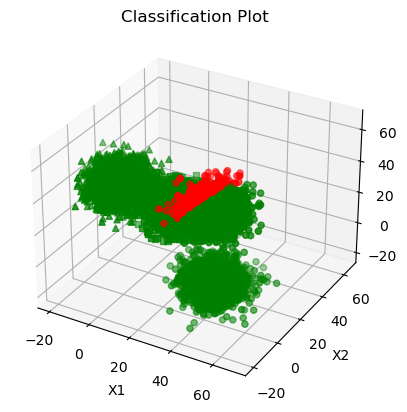

In [32]:
# Plot Classification results
fig = plt.figure()
ax = plt.axes(projection = "3d")
ax.scatter(X[(label==2) & (Decision == 1),0],X[(label==2) & (Decision == 1),1],X[(label==2) & (Decision == 1),2],color ='red', marker = 'o')
ax.scatter(X[(label==2) & (Decision == 2),0],X[(label==2) & (Decision == 2),1],X[(label==2) & (Decision == 2),2],color ='green', marker = 'o')
ax.scatter(X[(label==2) & (Decision == 0),0],X[(label==2) & (Decision == 0),1],X[(label==2) & (Decision == 0),2],color ='red', marker = 'o')
ax.scatter(X[(label==1) & (Decision == 1),0],X[(label==1) & (Decision == 1),1],X[(label==1) & (Decision == 1),2],color ='green', marker = 's')
ax.scatter(X[(label==1) & (Decision == 2),0],X[(label==1) & (Decision == 2),1],X[(label==1) & (Decision == 2),2],color ='red', marker = 's')
ax.scatter(X[(label==1) & (Decision == 0),0],X[(label==1) & (Decision == 0),1],X[(label==1) & (Decision == 0),2],color ='red', marker = 's')
ax.scatter(X[(label==0) & (Decision == 0),0],X[(label==0) & (Decision == 0),1],X[(label==0) & (Decision == 0),2],color ='green', marker = '^')
ax.scatter(X[(label==0) & (Decision == 2),0],X[(label==0) & (Decision == 2),1],X[(label==0) & (Decision == 2),2],color ='red', marker = '^')
ax.scatter(X[(label==0) & (Decision == 1),0],X[(label==0) & (Decision == 1),1],X[(label==0) & (Decision == 1),2],color ='red', marker = '^')
plt.xlabel('X1')
plt.ylabel('X2')
ax.set_zlabel('X3')
plt.title('Classification Plot')
plt.show()